In [1]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay
from mixed_naive_bayes import MixedNB

In [2]:
# Importing the pre-processed version of the data and turnign the target variable into a binary variable
df = pd.read_csv("preproc_data.csv")
df = df.iloc[:, 1:]
df['churn'] = df['churn'].map({'No': 0, 'Yes': 1})
df.describe(include='all')

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalintlcalls,totalintlcharge,numbercustomerservicecalls
count,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,0.136287,0.457745,0.905696,0.739873,0.159757,0.505552,0.500827,0.498255,0.494973,0.500983,0.494609,0.331994,0.503846,0.304536
std,0.343129,0.181672,0.292282,0.438750,0.279362,0.166457,0.168083,0.167155,0.166495,0.165245,0.166795,0.214228,0.160508,0.241370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,1.000000,0.000000,0.000000,0.390718,0.387931,0.384615,0.381154,0.390203,0.384615,0.200000,0.397727,0.200000
50%,0.000000,0.458333,1.000000,1.000000,0.000000,0.503606,0.500000,0.504274,0.495865,0.501166,0.495726,0.300000,0.509091,0.200000
75%,0.000000,0.578704,1.000000,1.000000,0.333333,0.618140,0.612069,0.615385,0.605849,0.614878,0.606838,0.500000,0.613636,0.400000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Separating the dependent from the independent variables
X = df.drop('churn', axis=1).to_numpy()
y = df.loc[:, 'churn'].to_numpy()

The Naive Bayes works under such assumptions that are best kept if the size of the dataset is large. Therefore, while balancing the classes, we will choose to do oversampling.

In [4]:
# Apply oversampling to the imbalanced class

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array before: yes {count_yes}, no {count_no}")

# Apply RandomOverSampler to address class imbalance
rus = RandomOverSampler(random_state=42)
Xtrain, ytrain = rus.fit_resample(Xtrain, ytrain)

count_no = np.sum(ytrain == 0)
count_yes = np.sum(ytrain == 1)
print(f"Array after: yes {count_yes}, no {count_no}")

Array before: yes 519, no 3273
Array after: yes 3273, no 3273


In [9]:
Xtrain

array([[0.38425926, 1.        , 1.        , ..., 0.3       , 0.27045455,
        0.        ],
       [0.45960455, 1.        , 0.        , ..., 0.2       , 0.51590909,
        0.4       ],
       [0.53240741, 1.        , 0.        , ..., 0.2       , 0.59545455,
        0.4       ],
       ...,
       [0.50925926, 0.        , 1.        , ..., 0.1       , 0.40681818,
        0.4       ],
       [0.68055556, 0.        , 1.        , ..., 0.1       , 0.45909091,
        0.        ],
       [0.2962963 , 1.        , 1.        , ..., 0.4       , 0.12727273,
        0.8       ]])

In [5]:
def evaluate(model, model_name, columns):
    predictions = model.predict(Xtest[:, columns])

    cm = metrics.confusion_matrix(ytest, predictions)

    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    total = tp + tn + fp + fn
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print(f"{model_name} Kernel SVM:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    print(f"Accuracy: {(tp+tn)/total}")
    print(f"Error: {1-(tp+tn)/total}")
    print(f"Recall: {recall}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Precision: {precision}")
    print(f"F1: {2*recall*precision/(recall+precision)}")

We have to choose an algorithm for Naive Bayes. In this case, we have both continuous and categorical variables. We will start by using only the continuous variables and use Gaussian Naive Bayes. Then, we will use only the categorical variables and use the Categorical Naive Bayes. Finally, we will use all the variables with the Mixed Naive Bayes. Since all of these models do not require any significant hyperparameters, we will use a simple holdout technique to evaluate them. 

In [6]:
exclude_gaussian = np.array([True, False, False, True, True, True, True, True, True, True, True, True, True])
exclude_categorical = ~exclude_gaussian

In [7]:
gnb=GaussianNB()
gnb.fit(Xtrain[:, exclude_gaussian],ytrain)

GaussianNB()

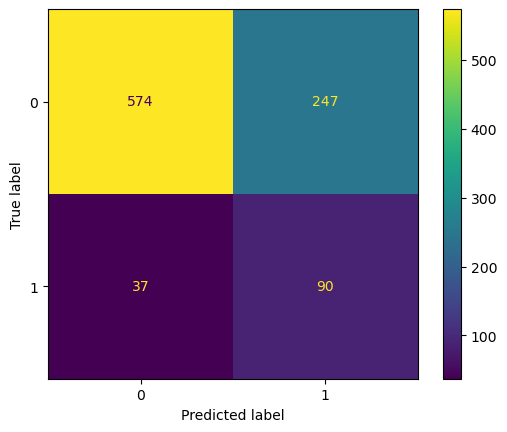

Gaussian Kernel SVM:
TP: 90, TN: 574, FP: 247, FN: 37
Accuracy: 0.70042194092827
Error: 0.29957805907172996
Recall: 0.7086614173228346
Specificity: 0.6991473812423873
Precision: 0.26706231454005935
F1: 0.3879310344827586


In [99]:
evaluate(gnb, "Gaussian", exclude_gaussian)

The scores show an overall decent accuracy and recall, making this a potential winner for the type of Naive Bayes algorithm we should choose.

In [100]:
cnb = CategoricalNB()
cnb.fit(Xtrain[:, exclude_categorical],ytrain)

CategoricalNB()

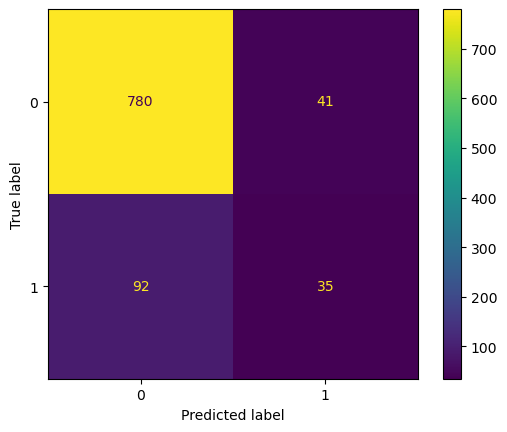

Categorical Kernel SVM:
TP: 35, TN: 780, FP: 41, FN: 92
Accuracy: 0.859704641350211
Error: 0.14029535864978904
Recall: 0.2755905511811024
Specificity: 0.9500609013398295
Precision: 0.4605263157894737
F1: 0.34482758620689663


In [101]:
evaluate(cnb, 'Categorical', exclude_categorical)

The accuracy on the categorical Naive Bayes is higher, but the recall is much worse. We will prefer using the Gaussian Naive Bayes over the Categorical.

In [102]:
mnb = MixedNB(categorical_features=[1, 2])
mnb.fit(Xtrain, ytrain)

MixedNB(alpha=0.5, var_smoothing=1e-09)

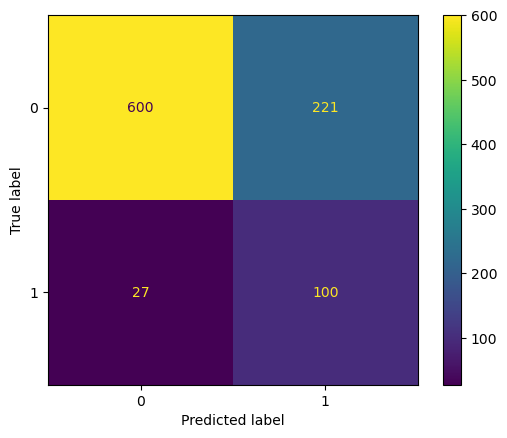

Mixed Kernel SVM:
TP: 100, TN: 600, FP: 221, FN: 27
Accuracy: 0.7383966244725738
Error: 0.2616033755274262
Recall: 0.7874015748031497
Specificity: 0.730816077953715
Precision: 0.3115264797507788
F1: 0.44642857142857145


In [103]:
evaluate(mnb, "Mixed", np.full(13, True))

It has overall better accuracy and recall, therefore we will choose this as the final Naive Bayes model. The fact that it uses more attributes and therefore more information can be what's differencing all of these models. Despite that, the overall model is not great and there may be better alternatives to use on this dataset than the Naive Bayes algorithm.